# Imports

In [128]:
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_array
from sklearn import decomposition
from sklearn.metrics.pairwise import cosine_similarity
import surprise
import implicit
from implicit.als import AlternatingLeastSquares
import pickle
import matplotlib.pyplot as plt

# DataFrame de test

In [2]:
df = pd.read_csv("globocom\\clicks_sample.csv",
                 sep=",")

In [3]:
df.columns

Index(['user_id', 'session_id', 'session_start', 'session_size',
       'click_article_id', 'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
      dtype='object')

In [4]:
df.drop(columns=['session_id', 'session_start', 'session_size',
       'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
       inplace = True)

In [5]:
df.head()

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


# Test Surprise

In [6]:
df.insert(2, "rating", 1)

In [7]:
df.head()

,user_id,click_article_id,rating
0,0,157541,1
1,0,68866,1
2,1,235840,1
3,1,96663,1
4,2,119592,1


In [8]:
reader = surprise.Reader(rating_scale=(0,1), line_format="user item rating")
data = surprise.Dataset.load_from_df(df, reader)

In [9]:
algo = surprise.SVDpp()

In [10]:
surprise.model_selection.cross_validate(algo,
                                        data,
                                        measures=["RMSE", "MAE"],
                                        cv = 5,
                                        verbose = True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0251  0.0285  0.0283  0.0290  0.0293  0.0280  0.0015  
MAE (testset)     0.0135  0.0157  0.0137  0.0149  0.0129  0.0142  0.0010  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    0.01    0.00    


{'test_rmse': array([0.02508126, 0.02852226, 0.02830038, 0.02903588, 0.02928006]),
 'test_mae': array([0.01353364, 0.01573622, 0.01371771, 0.01487798, 0.01294939]),
 'fit_time': (0.017998218536376953,
  0.018123865127563477,
  0.017000913619995117,
  0.020003557205200195,
  0.01700305938720703),
 'test_time': (0.006006479263305664,
  0.004999637603759766,
  0.004999399185180664,
  0.004998922348022461,
  0.004999876022338867)}

# Test Implicit

In [11]:
presdf = pd.DataFrame()
sdf = presdf.astype(dtype=pd.SparseDtype("int", 0))

In [12]:
df

,user_id,click_article_id,rating
0,0,157541,1
1,0,68866,1
2,1,235840,1
3,1,96663,1
4,2,119592,1
...,...,...,...
1878,705,119592,1
1879,705,284847,1
1880,706,108854,1
1881,706,96663,1


In [13]:
sdf.index = df.user_id.unique()

In [14]:
columns = df.click_article_id.unique()
for col in columns:
    sdf.insert(loc = 0, column = col, value = 0)
sdfdefrag = sdf.copy()
sdfdefrag

C:\Users\educh\AppData\Local\Temp\ipykernel_37276\3686462367.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sdf.insert(loc = 0, column = col, value = 0)


,162245,83472,84094,355863,260988,273355,299837,66326,141945,210448,...,44488,48915,236294,236065,30970,119592,96663,235840,68866,157541
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
for clk in df.index:
    sdfdefrag.loc[df.iloc[clk]["user_id"], df.iloc[clk]["click_article_id"]] +=1

In [16]:
sdfdefrag

,162245,83472,84094,355863,260988,273355,299837,66326,141945,210448,...,44488,48915,236294,236065,30970,119592,96663,235840,68866,157541
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
703,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
sdfdefrag.loc[666].values*sdfdefrag.loc[666].index

Index([     0,      0,      0,      0,      0,      0,      0,      0,      0,
            0,
       ...
            0,      0,      0,      0,      0, 119592,      0,      0,      0,
            0],
      dtype='int64', length=323)

In [18]:
model = AlternatingLeastSquares(factors=64, regularization = 0.05, alpha = 2.0)
model.fit(scipy.sparse.csr_matrix(sdfdefrag))

 67%|██████▋   | 10/15 [00:00<00:00, 17.21it/s]

100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


In [19]:
user_id = 666

In [20]:
ids, scores = model.recommend(
    userid = user_id, 
    user_items= scipy.sparse.csr_matrix(sdfdefrag.loc[666].values*sdfdefrag.loc[666].index), 
    N=5, 
    filter_already_liked_items=True)

In [21]:
ids

array([206, 173, 172,  86, 102])

In [22]:
scores

array([0.18479937, 0.15721217, 0.15347522, 0.1471369 , 0.0807377 ],
      dtype=float32)

# Test Content based

In [23]:
with open("globocom\\articles_embeddings.pickle", 'rb') as pkl:
    embedding = pickle.load(pkl)

In [24]:
embedding.shape

(364047, 250)

In [25]:
pca = decomposition.PCA(n_components = 50)
pca.fit(embedding)

PCA(n_components=50)

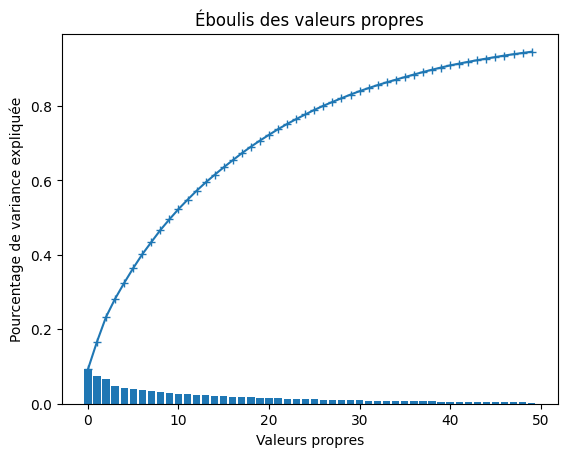

In [26]:
# Graphe de l'éboulis des valeurs propres
plt.bar(range(50), pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_.cumsum(), marker= '+')
plt.title("Éboulis des valeurs propres")
plt.xlabel('Valeurs propres')
plt.ylabel('Pourcentage de variance expliquée')
plt.show()

In [27]:
reduced = pca.transform(embedding)

In [28]:
reduced.shape

(364047, 50)

In [29]:
with open("PCA.pickle", 'wb') as file:
    pickle.dump(reduced, file)

In [30]:
reduced

array([[-2.1767828 , -1.3169111 , -1.0290499 , ...,  0.1077177 ,
         0.1577864 ,  0.10613775],
       [-1.7351742 ,  0.48990288,  3.268562  , ...,  0.31075567,
        -0.20858186,  0.05141195],
       [-0.91269326, -2.0893352 ,  1.8658754 , ..., -0.17984658,
        -0.44500896,  0.07934474],
       ...,
       [ 1.5641352 ,  4.05335   ,  2.134529  , ..., -0.3128998 ,
        -0.44842774,  0.41587645],
       [ 4.866369  ,  0.1518222 , -0.42444468, ..., -0.19286495,
        -0.32996595, -0.0550307 ],
       [ 1.1805271 ,  3.0404792 , -2.8629668 , ...,  1.5787369 ,
        -0.18925075, -0.14758292]], dtype=float32)

In [66]:
cosine_sim = cosine_similarity(reduced, reduced[666].reshape(1,-1))

In [67]:
cosine_sim

array([[-0.07123561],
       [-0.02302288],
       [ 0.01920066],
       ...,
       [ 0.01014212],
       [-0.05657046],
       [ 0.15140074]], dtype=float32)

In [68]:
sim_df = pd.DataFrame(cosine_sim)

In [69]:
sim_df.rename(columns={0:"sim"}, inplace=True)

In [70]:
sim_df

,sim
0,-0.071236
1,-0.023023
2,0.019201
3,0.177405
4,0.315637
...,...
364042,0.035693
364043,0.196127
364044,0.010142
364045,-0.056570


In [71]:
sim_df.sort_values(by="sim", ascending=False, inplace=True)

In [72]:
sim_df

,sim
666,1.000000
115223,0.871279
258590,0.802039
260519,0.776431
258271,0.772367
...,...
180640,-0.533440
318212,-0.544433
336598,-0.544875
321589,-0.551865


In [106]:
sim_df.loc[sim_df.sim == sim_df.iloc[1].values[0]].index[0]

115223

In [108]:
sim_df.insert(1, "ortho", 1-abs(sim_df.sim))

In [109]:
sim_df.sort_values(by="ortho", ascending=False)

,sim,ortho
21090,-4.325993e-07,1.000000
111236,-7.408671e-07,0.999999
348919,-7.575145e-07,0.999999
240686,1.271954e-06,0.999999
85070,-1.628534e-06,0.999998
...,...,...
258271,7.723674e-01,0.227633
260519,7.764305e-01,0.223569
258590,8.020394e-01,0.197961
115223,8.712792e-01,0.128721


In [111]:
sim_df.loc[sim_df.ortho == sim_df.ortho.max()].index[0]

21090

In [112]:
sim_df.loc[sim_df.index == 227552]

,sim,ortho
227552,-0.000361,0.999639


# Scale-up data

In [114]:
def sp_loc_incr(df, index, columns, val):
    """ Insert data in a DataFrame with SparseDtype format

    Only applicable for pandas version > 0.25

    Args
    ----
    df : DataFrame with series formatted with pd.SparseDtype
    index: str, or list, or slice object
        Same as one would use as first argument of .loc[]
    columns: str, list, or slice
        Same one would normally use as second argument of .loc[]
    val: insert values

    Returns
    -------
    df: DataFrame
        Modified DataFrame

    """

    # Save the original sparse format for reuse later
    spdtypes = df.dtypes[columns]

    # Convert concerned Series to dense format
    df[columns] = df[columns].sparse.to_dense()

    # Do a normal insertion with .loc[]
    df.loc[index, columns] = val

    # Back to the original sparse format
    df[columns] = df[columns].astype(spdtypes)

    return df

In [34]:
presdf = pd.DataFrame()
sdf = presdf.astype(dtype=pd.SparseDtype("int", 0))
index = []
columns = []
nb_hours = 23

for hour in range(0,nb_hours+1):
    print(hour)
    df = pd.read_csv("globocom\\clicks\\clicks\\clicks_hour_"+f'{hour:03}'+".csv",
                    sep=",")
    if hour == 0:
        index = df.user_id.unique().tolist()
        columns = df.click_article_id.unique().tolist()
    else:
        users_in_df = df.user_id.unique()
        for user in users_in_df:
            if user not in index:
                index.append(user)
        articles_in_df = df.click_article_id.unique()
        for article in articles_in_df:
            if article not in columns:
                columns.append(article)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [35]:
ssp = csr_array((len(index), len(columns)), dtype=np.uint8)#.toarray()
sdf = pd.DataFrame.sparse.from_spmatrix(ssp, index=index, columns=columns)
print("sdf created")
for hour in range(0,nb_hours+1):
    print(hour)
    df = pd.read_csv("globocom\\clicks\\clicks\\clicks_hour_"+f'{hour:03}'+".csv",
                    sep=",")
    for clk in df.index:
        sp_loc_incr(sdf,
                df.iloc[clk]["user_id"],
                df.iloc[clk]["click_article_id"],
                1)        


sdf created
0
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

In [ ]:
sdf

,157541,68866,235840,96663,119592,30970,236065,236294,48915,44488,...,111836,217868,10439,354186,354507,354187,87220,88883,88882,38886
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sdf.to_pickle("SDF_24.pickle")

In [ ]:
presdf = pd.DataFrame()
sdf = presdf.astype(dtype=pd.SparseDtype("int", 0))
users = []
articles = []
nb_hours = 384

for hour in range(0,nb_hours+1):
    df = pd.read_csv("globocom\\clicks\\clicks\\clicks_hour_"+f'{hour:03}'+".csv",
                    sep=",")
    if hour == 0:
        users = df.user_id.unique().tolist()
        articles = df.click_article_id.unique().tolist()
    else:
        users_in_df = df.user_id
        for user in users_in_df:
            users.append(user)
        articles_in_df = df.click_article_id
        for article in articles_in_df:
            articles.append(article)


In [ ]:
users = list(set(users))
articles = list(set(articles))

In [129]:
nb_hours = 384

for hour in range(0,nb_hours+1):
    print(hour)
    df = pd.read_csv("globocom\\clicks\\clicks\\clicks_hour_"+f'{hour:03}'+".csv",
                    sep=",")
    df.drop(columns=['session_id', 'session_start', 'session_size',
       'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
       inplace = True)
    if hour == 0:
        df_rel = df
    else:
        df_rel = pd.concat([df_rel, df])
df_rel.reset_index(inplace=True, drop=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [130]:
df_rel.to_csv('df_rel.csv')

In [ ]:
df_rel.to_pickle("df_rel.pickle")

In [134]:
df_rel = pd.read_csv('df_rel.csv', index_col='Unnamed: 0')

In [135]:
df_rel

,user_id,click_article_id,click_timestamp
0,0,157541,1506826828020
1,0,68866,1506826858020
2,1,235840,1506827017951
3,1,96663,1506827047951
4,2,119592,1506827090575
...,...,...,...
2988176,10051,84911,1508211557302
2988177,322896,30760,1508211672520
2988178,322896,157507,1508211702520
2988179,123718,234481,1508211513583


In [119]:
pd.to_datetime(df_rel.click_timestamp, unit='ms')
epoch_ms = 6*60*60*1000
print(pd.to_datetime(df_rel.click_timestamp, unit='ms'))

0         2017-10-01 03:00:28.020
1         2017-10-01 03:00:58.020
2         2017-10-01 03:03:37.951
3         2017-10-01 03:04:07.951
4         2017-10-01 03:04:50.575
                    ...          
2988176   2017-10-17 03:39:17.302
2988177   2017-10-17 03:41:12.520
2988178   2017-10-17 03:41:42.520
2988179   2017-10-17 03:38:33.583
2988180   2017-10-17 03:39:03.583
Name: click_timestamp, Length: 2988181, dtype: datetime64[ns]


In [124]:
df_rel.loc[(df_rel.user_id == 333) & (df_rel.click_article_id == 108854)].click_timestamp.values[0]

1506827883039

In [126]:
df_rel_epoch = df_rel.loc[(df_rel.click_timestamp <= 1506827883039) &
                        (df_rel.click_timestamp >= 1506827883039 - epoch_ms)]
df_rel_epoch

,user_id,click_article_id,click_timestamp
0,0,157541,1506826828020
1,0,68866,1506826858020
2,1,235840,1506827017951
3,1,96663,1506827047951
4,2,119592,1506827090575
...,...,...,...
1120,422,235840,1506827879343
1126,425,348103,1506827850848
1129,426,108854,1506827855009
1131,427,106984,1506827882067


In [127]:
df_rel_epoch.loc[(df_rel_epoch.user_id == 333) & (df_rel_epoch.click_article_id == 108854)].click_timestamp.values[0]

1506827883039

In [ ]:
userQuery = 45770
usersRead =[]
indexQuery = []
i=1
articlesRead = df_rel_epoch.loc[df_rel_epoch["user_id"] == userQuery].click_article_id.values.tolist()
for art in articlesRead:
    usersRead += df_rel_epoch.loc[df_rel["click_article_id"] == art].user_id.values.tolist()
usersRead = list(set(usersRead))
for user in usersRead:
    print("Processing user ", i, " of ", len(usersRead))
    i+=1
    indexQuery += df_rel_epoch.loc[df_rel["user_id"] == user].index.tolist()
indexQuery = list(set(indexQuery))

Processing user  1  of  28
Processing user  2  of  28
Processing user  3  of  28
Processing user  4  of  28
Processing user  5  of  28
Processing user  6  of  28
Processing user  7  of  28
Processing user  8  of  28
Processing user  9  of  28
Processing user  10  of  28
Processing user  11  of  28
Processing user  12  of  28
Processing user  13  of  28
Processing user  14  of  28
Processing user  15  of  28
Processing user  16  of  28
Processing user  17  of  28
Processing user  18  of  28
Processing user  19  of  28
Processing user  20  of  28
Processing user  21  of  28
Processing user  22  of  28
Processing user  23  of  28
Processing user  24  of  28
Processing user  25  of  28
Processing user  26  of  28
Processing user  27  of  28
Processing user  28  of  28


In [ ]:
df_rel_red = df_rel.iloc[indexQuery]

In [ ]:
presdf = pd.DataFrame()
sdf = presdf.astype(dtype=pd.SparseDtype("int", 0))

In [ ]:
index = df_rel_red.user_id.unique()
columns = df_rel_red.click_article_id.unique()

In [ ]:
sdf.index = index
for col in columns:
    sdf.insert(loc = 0, column = col, value = 0)
sdfdefrag = sdf.copy()

In [ ]:
for clk in df_rel_red.index:
    sdfdefrag.loc[df_rel.iloc[clk]["user_id"], df_rel.iloc[clk]["click_article_id"]] +=1

# ssp = csr_array((len(index), len(columns)), dtype="int")#.toarray()
# sdf = pd.DataFrame.sparse.from_spmatrix(ssp, index=index, columns=columns)


# for clk in df_rel_red.index:
#     sp_loc_incr(sdf,
#             df_rel.iloc[clk]["user_id"],
#             df_rel.iloc[clk]["click_article_id"],
#             1)   

In [ ]:
sdfdefrag.max().max()

2

In [ ]:
sdfdefrag

,108855,159371,237524,203288,42737,63294,160453,62392,157227,276970,...,65468,61809,61382,65828,308907,42437,141128,123909,42693,30795
184046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
118893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
127697,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,1,0
48822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
45770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
179197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
159686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
27253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
10662,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
141625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
model = AlternatingLeastSquares(factors=64, regularization = 0.05, alpha = 2.0)
model.fit(scipy.sparse.csr_matrix(sdfdefrag))

100%|██████████| 15/15 [00:00<00:00, 121.44it/s]


In [ ]:
sdfdefrag.loc[65369].values*sdfdefrag.loc[65369].reset_index().index

Index([ 0,  1,  2,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 26,  0,  0,  0,  0, 31,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       54,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, 81,  0],
      dtype='int64')

In [ ]:
user_id = 65369
ids, scores = model.recommend(
    userid = sdfdefrag.index.get_loc(user_id), 
    user_items= scipy.sparse.csr_matrix(sdfdefrag.loc[user_id].values*sdfdefrag.loc[user_id].reset_index().index), 
    N=5, 
    filter_already_liked_items=True)

In [ ]:
ids

array([ 0, 19, 62, 60, 82])

In [ ]:
scores

array([0.99368906, 0.0033518 , 0.00323701, 0.00272644, 0.00230397],
      dtype=float32)

In [139]:
sdfdefrag.iloc[ids]

,162245,83472,84094,355863,260988,273355,299837,66326,141945,210448,...,44488,48915,236294,236065,30970,119592,96663,235840,68866,157541
206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
